# 데이터 가져오기 및 전처리

- [Google Colab에서 실행하기](https://colab.research.google.com/github/JuhongPark/snu-fintech-ai/blob/develop/Lending_Club_SSAE.ipynb)

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgbm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/Users/jisu/miniconda/envs/torch/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## 데이터 다운로드하기

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# # 모든 행이 화면에 표시되도록 설정합니다.
# pd.set_option('display.max_rows', None)
# file_path = '/content/drive/MyDrive/lending_club_2020_train.csv'
# df = pd.read_csv(file_path)

# 모든 행이 화면에 표시되도록 설정합니다.
pd.set_option('display.max_rows', None)

file_path = '../LendingClub/LC_Data_Cleaned_2.csv'
df = pd.read_csv(file_path)

## 데이터 구조 훑어 보기

In [3]:
df.head()

,loan_amnt,term,int_rate,installment,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,debt_settlement_flag,loan_status_encoded
0,12800.0,0,0.1433,439.53,C2,Brivo Systems,1.0,0,132500.0,1,...,88.0,50.0,0.0,0.0,393952.0,79834.0,8593.0,82659.0,N,0
1,24000.0,0,0.0769,748.65,A4,IT System Administrator,10.0,0,70000.0,0,...,100.0,100.0,0.0,0.0,126684.0,25691.0,22600.0,21384.0,N,0
2,18000.0,0,0.1249,602.08,B4,Administrator,2.0,0,69500.0,0,...,97.8,100.0,0.0,0.0,271341.0,137583.0,4600.0,129718.0,N,1
3,5600.0,0,0.1099,183.32,B3,NaN,0.0,1,42000.0,0,...,88.9,100.0,0.0,0.0,22593.0,13074.0,2100.0,16093.0,N,0
4,5600.0,0,0.1620,197.44,C4,Lab Technician/Secretary II,4.0,1,60000.0,0,...,100.0,100.0,0.0,0.0,51804.0,41327.0,19600.0,28775.0,Y,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75090 entries, 0 to 75089
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   loan_amnt                       75090 non-null  float64
 1   term                            75090 non-null  int64  
 2   int_rate                        75090 non-null  float64
 3   installment                     75090 non-null  float64
 4   sub_grade                       75090 non-null  object 
 5   emp_title                       70225 non-null  object 
 6   emp_length                      75090 non-null  float64
 7   home_ownership                  75090 non-null  int64  
 8   annual_inc                      75090 non-null  float64
 9   verification_status             75090 non-null  int64  
 10  url                             75090 non-null  object 
 11  title                           75090 non-null  object 
 12  dti                             

In [5]:
df.shape

(75090, 64)

In [6]:
df.dtypes

loan_amnt                         float64
term                                int64
int_rate                          float64
installment                       float64
sub_grade                          object
emp_title                          object
emp_length                        float64
home_ownership                      int64
annual_inc                        float64
verification_status                 int64
url                                object
title                              object
dti                               float64
delinq_2yrs                       float64
earliest_cr_line                   object
fico_range_low                    float64
fico_range_high                   float64
inq_last_6mths                    float64
mths_since_last_delinq            float64
mths_since_last_record            float64
open_acc                          float64
pub_rec                           float64
revol_bal                         float64
revol_util                        

## 데이터 전처리

In [4]:
# 범주형변수 처리
df = df.select_dtypes(include = [np.number])

# 결측치 처리
df = df.fillna(0)
df.head()

,id,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,dti,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,loan_status_encoded
0,6519928,12800.0,0,0.1433,439.53,1.0,0,132500.0,1,9.78,...,3.0,88.0,50.0,0.0,0.0,393952.0,79834.0,8593.0,82659.0,0
1,26359465,24000.0,0,0.0769,748.65,10.0,0,70000.0,0,17.32,...,0.0,100.0,100.0,0.0,0.0,126684.0,25691.0,22600.0,21384.0,0
2,13897978,18000.0,0,0.1249,602.08,2.0,0,69500.0,0,23.71,...,2.0,97.8,100.0,0.0,0.0,271341.0,137583.0,4600.0,129718.0,1
3,15429979,5600.0,0,0.1099,183.32,0.0,1,42000.0,0,12.14,...,1.0,88.9,100.0,0.0,0.0,22593.0,13074.0,2100.0,16093.0,0
4,8975826,5600.0,0,0.1620,197.44,4.0,1,60000.0,0,24.56,...,1.0,100.0,100.0,0.0,0.0,51804.0,41327.0,19600.0,28775.0,1


In [5]:
target = 'loan_status_encoded'


X = df.drop(columns=[target])
y = df[target]

# 모델 선택과 훈련

## 테스트 세트 만들기

In [6]:
# Torch 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 표준화 (훈련 데이터에 fit_transform, 테스트 데이터에 transform)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# 파라미터 설정

# For model
learning_rate = 0.01

# For training
n_epochs = 10000


## SSAE 모델 정의

- 오토인코더(Autoencoder):
    - 구조: 오토인코더는 입력 데이터를 저차원 공간으로 압축한 뒤, 이를 다시 복원하는 과정을 거친다. 기본적으로 입력과 출력이 동일한 형태를 가지며, 데이터의 중요한 특징만을 추출하여 저차원 공간에 표현한다.
    - 목적: 데이터의 효율적인 표현 학습을 목적으로 합니다. 데이터의 노이즈 제거, 차원 축소, 특징 학습 등에 사용된다.
    - 손실 함수: 주로 MSE(Mean Squared Error)와 같은 재구성 오류를 최소화하는 방식으로 학습.

- 스파스 스택 오토인코더(Sparse Stacked Autoencoder, SSAE):
    - 구조: SSAE는 오토인코더의 변형으로, 네트워크가 특정 제약 조건을 갖도록 하여 학습한다. "Sparse"라는 용어는 네트워크의 뉴런이 활성화되는 비율을 조절하여, 특정 뉴런만이 활성화되도록 강제하는 제약을 뜻한다.
    - 목적: 뉴런의 활성화 빈도를 제어함으로써 데이터의 중요한 특징을 더욱 잘 학습하도록 유도한다. 스파스 제약 조건을 통해 네트워크는 특정 입력에 대해 일부 뉴런만 활성화되도록 학습하며, 이를 통해 보다 효율적인 특징 학습을 할 수 있다.
    - 노이즈 추가: SSAE는 종종 노이즈를 포함한 데이터를 입력으로 받아들이고, 깨끗한 출력을 생성하도록 학습된다. 이를 통해 모델은 원본 데이터를 더 잘 복원하도록 학습된다.
    - 손실 함수: 일반 오토인코더와 마찬가지로 재구성 오류를 최소화하는 방향으로 학습되지만, 추가적으로 스파스 제약 조건을 만족시키기 위해 추가적인 손실 항이 포함될 수 있다.

In [9]:
# Denoising SSAE 모델 정의
class DenoisingSSAE(nn.Module):
    def __init__(self, input_dim):
        super(DenoisingSSAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),

        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Noise 추가 함수
def add_noise(data, noise_factor=0.2):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    noisy_data = np.clip(noisy_data, 0., 1.)
    return noisy_data

In [10]:
# 모델 생성 및 학습 설정
input_dim = X_train.shape[1]
model = DenoisingSSAE(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# 모델 학습
epochs = n_epochs
X_train_noisy = add_noise(X_train)

for epoch in range(epochs):
    model.train()
    inputs = torch.FloatTensor(X_train_noisy).to(device)
    targets = torch.FloatTensor(X_train).to(device)

    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0 or epoch == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    # # 매 에포크마다 손실 출력
    # print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/10000], Loss: 1.0089
Epoch [1000/10000], Loss: 0.4358
Epoch [2000/10000], Loss: 0.4162
Epoch [3000/10000], Loss: 0.4056
Epoch [4000/10000], Loss: 0.3907
Epoch [5000/10000], Loss: 0.3844
Epoch [6000/10000], Loss: 0.3753
Epoch [7000/10000], Loss: 0.3679


In [ ]:
# SSAE 모델에서 차원 축소된 데이터 생성
model.eval()
X_train_encoded_ssae = model.encoder(torch.FloatTensor(X_train).to(device)).detach().cpu().numpy()
X_test_encoded_ssae = model.encoder(torch.FloatTensor(X_test).to(device)).detach().cpu().numpy()

## 모델 평가함수 및 실행

In [17]:
# 평가함수 정의
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [18]:
def evaluate_models_shap1(model, X_train_encoded_ssae, X_test_encoded_ssae):
    # Independent Masker와 LinearExplainer를 사용한 Shapley Value 계산
    masker = shap.maskers.Independent(X_train_encoded_ssae)
    explainer = shap.LinearExplainer(model, masker=masker)
    shap_values = explainer(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])

def evaluate_models_shap2(model, X_test_encoded_ssae):
    # TreeExplainer를 사용한 Shapley Value 계산
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test_encoded_ssae)

    # summary_plot을 사용한 Shapley Value 시각화
    shap.summary_plot(shap_values, X_test_encoded_ssae, feature_names=[f"Encoded_{i}" for i in range(X_test_encoded_ssae.shape[1])])


In [19]:
# 모델 정의
linear_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
}

ensemble_models = {
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBoost Classifier": xgb.XGBClassifier(),
    "LightGBM Classifier": lgbm.LGBMClassifier()
}

/Users/jisu/miniconda/envs/torch/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


## 테스트세트로 평가하기

** Evaluating Logistic Regression on SSAE Encoded Data: 
Accuracy: 0.5619, Precision: 0.5502, Recall: 0.6784, F1 Score: 0.6076, R² Score: -0.7523


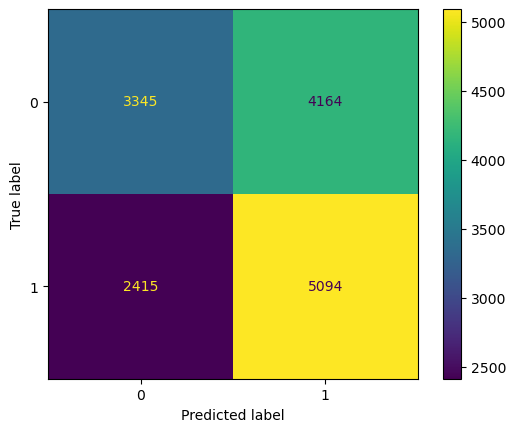

** Evaluating Logistic Regression's Shapley Value: 


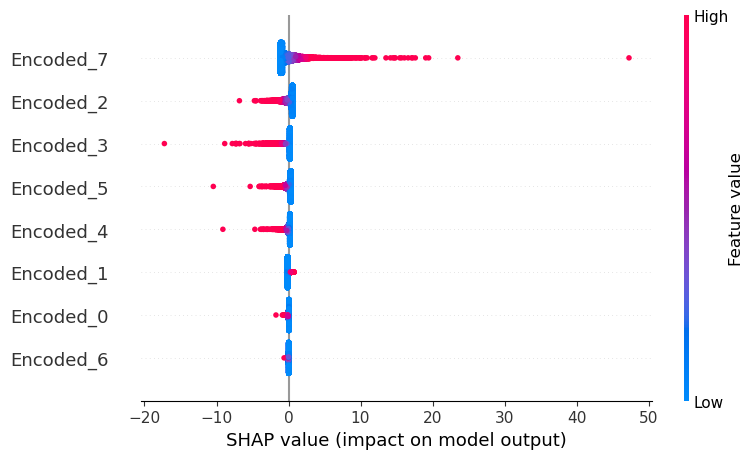

In [20]:
for model_name, model in linear_models.items():
    print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
    evaluate_model(model, X_train_encoded_ssae, X_test_encoded_ssae, y_train, y_test)

    print(f"** Evaluating {model_name}'s Shapley Value: ")
    evaluate_models_shap1(model, X_train_encoded_ssae, X_test_encoded_ssae)

** Evaluating Random Forest Classifier on SSAE Encoded Data: 
Accuracy: 0.5534, Precision: 0.5552, Recall: 0.5375, F1 Score: 0.5462, R² Score: -0.7864


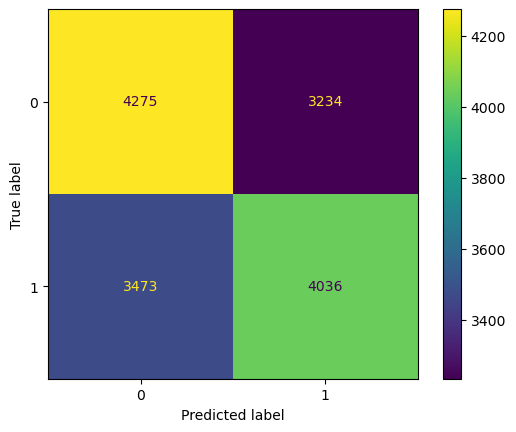

In [21]:
for model_name, model in ensemble_models.items():
    print(f"** Evaluating {model_name} on SSAE Encoded Data: ")
    evaluate_model(model, X_train_encoded_ssae, X_test_encoded_ssae, y_train, y_test)

    print(f"** Evaluating {model_name}'s Shapley Value: ")
    evaluate_models_shap2(model, X_test_encoded_ssae)